<a href="https://colab.research.google.com/github/19522531/CS117.L21/blob/main/Final_Project/CS117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vncorenlp
!pip install skicit-learn
!pip install ftfy

     |████████████████████████████████| 2.6 MB 13.4 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=7d565b8031c59fb462e9c3c1ff0e1a03297abcd661dd9166eeacb80d471d6b57
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
ERROR: Could not find a version that satisfies the requirement skicit-learn (from versions: none)
ERROR: No matching distribution found for skicit-learn
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41934 sha256=804682af17e4ab848d1a828deb8be7682434dd89e0e68fe954b2eea3e0a27b25
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV


In [4]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/CS117/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

## Khám phá dữ liệu

In [16]:
data = pd.read_excel("/content/drive/MyDrive/CS117/dataset.xlsx")

In [17]:
data

,Unnamed: 0,Evaluate,Label
0,0,Hướng dẫn dễ hiểu,1
1,1,khong co,2
2,2,Thầy đưa ra các phương thức học tập hiệu quả v...,1
3,3,Tận tâm giảng dạy,1
4,4,Giaó viên tận tình chỉ dẫn cho sinh viên,1
...,...,...,...
1364,1364,"Thầy đi đúng giờ,giảng những cái chưa hiểu",1
1365,1365,"Hơi khó tính, điểm tính không rõ ràng làm điểm...",0
1366,1366,"Thầy cho bài tập không phong phú, cần cho nhiề...",0
1367,1367,"Hướng dẫn cụ thể rõ ràng, nhiệt tình với sinh ...",1


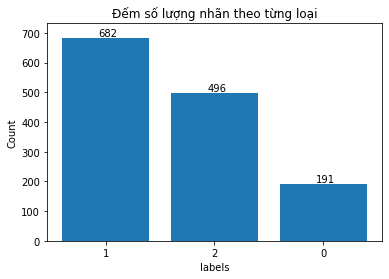

In [18]:
import matplotlib.pyplot as plt
 
# Đếm số lượng nhãn theo từng loại
Label_counts = Counter(data['Label']) 
# Chuẩn bị dữ liệu:
# Sort Số lượng giảm dần
Counts = sorted(Label_counts.values(), reverse=True)
labels = sorted(Label_counts, key=Label_counts.__getitem__, reverse=True)
 
# Chỉ số các món ăn
ind_labels= range(len(Label_counts))
 
# Vẽ biểu đồ cột
plt.bar(ind_labels, Counts, align='center')
plt.xticks(ind_labels, labels)
 
# Label x, y axit
plt.xlabel('labels')
plt.ylabel('Count')
# Label title of bar char
plt.title('Đếm số lượng nhãn theo từng loại')
 
# Thêm các giá trị trên mỗi cột
for x, y in zip(ind_labels, Counts):
    plt.text(x+0.02, y+0.05, '%d' % y, ha='center', va= 'bottom')
 
# Tăng trục y thêm 20 đơn vị
plt.ylim(0, Counts[0] + 50)
 
# Cuối cùng là show kết quả!!!
plt.show()

In [44]:
#câu có độ dài lớn nhất là 130 từ
max = 0
for i in data['Evaluate']:
  if (max<len(i.split())):
    max= len(i.split())
    sent = i
print(max)
print(sent)

130
Dạ, thầy dạy rất chi tiết. Em từ là 1 sinh viên chưa biết lập trình, sau khi học thầy được gần 3 tháng thì em đã có được kiến thức cơ bản khá vững trong lập trình cũng như các kiến thức tư duy về toán học. Thầy có cách dạy rất rất lạ và hay vì thầy có các video ở youtube để tụi em ôn bài hay không nắm kĩ bài thì có thể xem lại, đặc biệt là giúp tụi em có khả năng tự học cao hơn. Ngoài ra, tính tình thầy rất nghiêm, chắc có lẽ thầy nghiêm để tụi em học và tập trung tốt hơn nhưng những lúc nào cần vui hay thoải mái thì thầy rất đẹp trai và thân thiện.


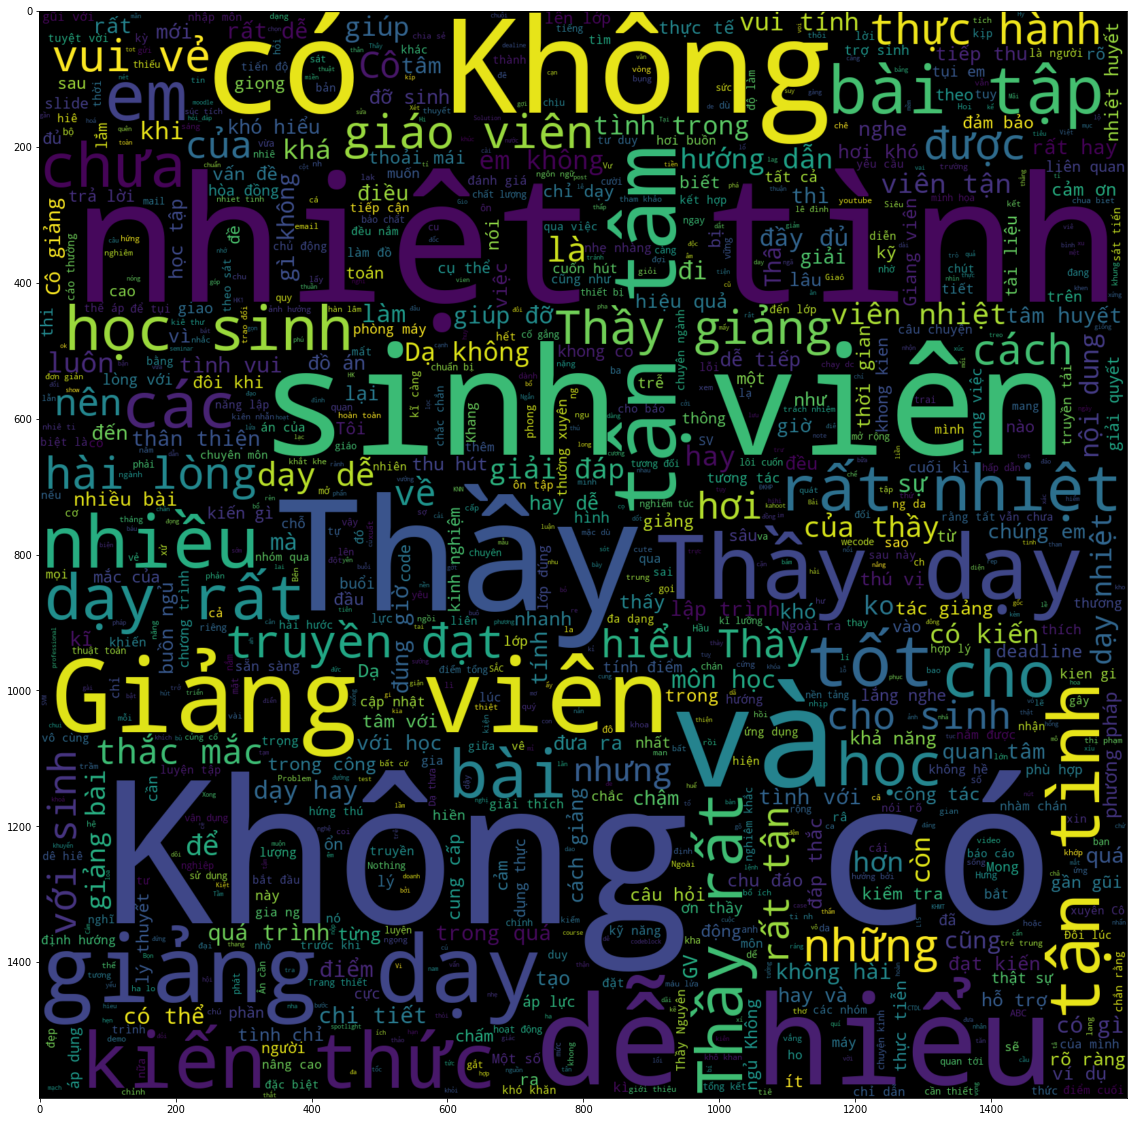

In [48]:
# characteristics are most common in these reviews
plt.figure(figsize = (20,20)) 
text = " ".join(sent for sent in data['Evaluate'])
wc = WordCloud(max_words = 2000 , width = 1600 , height = 1600).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

##Tiền xử lý dữ liệu

In [49]:
def processing(text, word_segment , lower_case):  
  #remove các ký tự kéo dài
  text = re.sub(r'([A-Za-zaăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ])\1+', lambda m: m.group(1), text)
  #Remove sign
  sign = r"[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~\'\'""''``]"
  text =re.sub(sign, " ", text)
   # Chuyển thành chữ thường|
  if lower_case == True:
    text = text.lower()
  if word_segment == True:
    text = re.sub("\\s+", " ", text)
  #chuẩn hóa các từ không
  replace_list = json.load(open("/content/drive/MyDrive/CS117/replace_list.txt"))
  for k, v in replace_list.items():
        text = text.replace(k, v)
  if word_segment == True:
    segments = rdrsegmenter.tokenize(text)
    text = " ".join(segments[0])
  return text

In [123]:
import json
Evaluate = []
label = data["Label"]
for text in data["Evaluate"]:
  Evaluate.append(processing(text, True, True)) 

In [124]:
#chia tập train tập test
x_train, x_test, y_train, y_test = train_test_split(Evaluate,label,test_size=0.1,train_size=0.9)

##trích xuất đặc trưng

###Sử dụng phương pháp Bag of Word

In [136]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

### Sử dụng mô hình Logistic Regression

In [139]:
clf = LogisticRegression(penalty='l2',max_iter=200).fit(X_train, Y_train)

In [141]:
predict = clf.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(Y_test, predict,  target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        29
     class 1       0.49      0.77      0.60        66
     class 2       0.33      0.24      0.28        42

    accuracy                           0.45       137
   macro avg       0.27      0.34      0.29       137
weighted avg       0.34      0.45      0.37       137



### Sử dụng mô hình SVM

In [137]:
clf = LinearSVC(C=1.0, tol = 0.0001)
clf.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [138]:
predict = clf.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(Y_test, predict,  target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.44      0.14      0.21        29
     class 1       0.46      0.67      0.54        66
     class 2       0.34      0.26      0.30        42

    accuracy                           0.43       137
   macro avg       0.42      0.36      0.35       137
weighted avg       0.42      0.43      0.40       137



### sử dụng mô hình kết hợp Voting Ensemble

In [142]:
log_clf = LogisticRegression(penalty='l2', max_iter=100, C=1)
svm_clf = LinearSVC(C=1.0, tol = 0.0001)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf)],
    voting='hard')

In [143]:
ens_bow = voting_clf.fit(X_train, Y_train)
predict = ens_bow.predict(X_test)

In [144]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(Y_test, predict,  target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.44      0.14      0.21        29
     class 1       0.48      0.76      0.59        66
     class 2       0.38      0.21      0.27        42

    accuracy                           0.46       137
   macro avg       0.43      0.37      0.36       137
weighted avg       0.44      0.46      0.41       137



### Sử dụng phương pháp TF-IDF

In [58]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
Y_train = np.array(y_train)
Y_test = np.array(y_test)

## Khởi tạo mô hình

### Sử dụng thuật toán SVM

In [62]:
clf = LinearSVC(C=1.0, tol = 0.0001)
clf.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [63]:
predict = clf.predict(X_test)

In [64]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(Y_test, predict,  target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.79      0.79      0.79        29
     class 1       0.92      0.92      0.92        66
     class 2       0.93      0.93      0.93        42

    accuracy                           0.90       137
   macro avg       0.88      0.88      0.88       137
weighted avg       0.90      0.90      0.90       137



### Sử dụng thuật toán Logistic Regression

In [73]:
clf = LogisticRegression(penalty='l2',max_iter=200).fit(X_train, Y_train)

In [74]:
predict = clf.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(Y_test, predict,  target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.69      0.77        29
     class 1       0.86      1.00      0.92        66
     class 2       1.00      0.88      0.94        42

    accuracy                           0.90       137
   macro avg       0.91      0.86      0.88       137
weighted avg       0.90      0.90      0.89       137



### Mô hình kết hợp Voting Ensemble

In [88]:
log_clf = LogisticRegression(penalty='l2', max_iter=100, C=1)
svm_clf = LinearSVC(C=1.0, tol = 0.0001)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf)],
    voting='hard')

In [91]:
ens_bow = voting_clf.fit(X_train, Y_train)
predict = ens_bow.predict(X_test)

In [92]:
predict = clf.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(Y_test, predict,  target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.69      0.77        29
     class 1       0.86      1.00      0.92        66
     class 2       1.00      0.88      0.94        42

    accuracy                           0.90       137
   macro avg       0.91      0.86      0.88       137
weighted avg       0.90      0.90      0.89       137



### So sánh kết quả giữa các phương pháp 
- Nhóm sẽ chú trọng vào chỉ số weighted avg F1-score
(F1-score là trung bình điều hòa (harmonic mean) của precision và recall)
- Tại vì số lượng các nhãn trong data không cân bằng nên weighted average sẽ tổng hợp các đóng góp của tất cả các lớp để tính toán số liệu trung bình. Chỉ số này sẽ đánh giá một cách khách quan cho mô hình.

In [147]:
result = [0.37,0.40,0.41, 0.89,0.90,0.89]
name = ["BOW_Log", "BOW_Svm", "BOW_Voting", "TF-IDF_Log", "TF-IDF_Svm", "TF-IDF_Voting"]

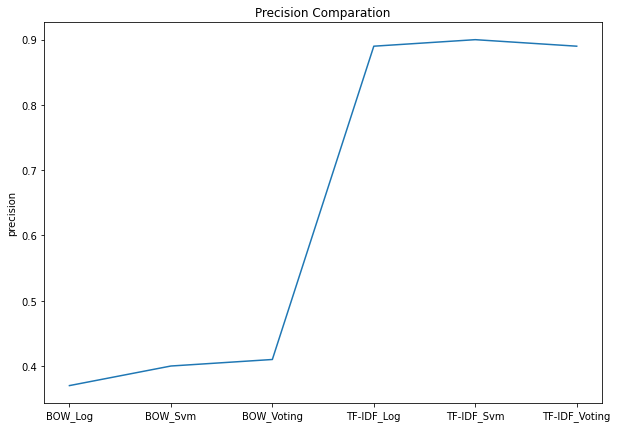

In [148]:
fig = plt.figure(figsize =(10, 7))
plt.plot(name, result)
plt.title('Precision Comparation')

plt.ylabel('precision')
plt.show()

#Nhận xét:
- Qua quá trình thử nghiệm nhiều phương pháp trích xuất đặc trưng và các phương pháp máy học đã rút ra được với phương pháp rút trích đặc trưng TF-IDF và mô hình SVM cho kết quả tốt nhất. Tuy nhiên với mô hình kết hợp giữa Logistic Regression và mô hình SVM cũng cho kết quả cũng sấp xỉ ngang bằng mô hình SVM.

